In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

### 1- Upload data 

In [21]:
df = pd.read_csv('final_data.csv')

df.replace([np.inf, -np.inf], 1, inplace=True)


In [22]:
# Get number of columns
num_columns = len(df.columns)

# Get column names
column_names = df.columns.tolist()

# Print the results
print(f"🧾 Total columns: {num_columns}")
print("📋 Column names:")
for i, name in enumerate(column_names, start=1):
    print(f"{i}. {name}")

🧾 Total columns: 251
📋 Column names:
1. UniProt ID
2. Gene
3. Mutation
4. Class
5. ANDN920101
6. ARGP820101
7. ARGP820102
8. ARGP820103
9. BEGF750101
10. BEGF750102
11. BEGF750103
12. BHAR880101
13. BIGC670101
14. BIOV880101
15. bf_peptide
16. af_peptide
17. bf_peptide_ratio
18. af_peptide_ratio
19. rsa_-5
20. asa_-5
21. p[q3_H]_-5
22. p[q3_E]_-5
23. p[q3_C]_-5
24. p[q8_G]_-5
25. p[q8_H]_-5
26. p[q8_I]_-5
27. p[q8_B]_-5
28. p[q8_E]_-5
29. p[q8_S]_-5
30. p[q8_T]_-5
31. p[q8_C]_-5
32. phi_-5
33. psi_-5
34. disorder_-5
35. rsa_-4
36. asa_-4
37. p[q3_H]_-4
38. p[q3_E]_-4
39. p[q3_C]_-4
40. p[q8_G]_-4
41. p[q8_H]_-4
42. p[q8_I]_-4
43. p[q8_B]_-4
44. p[q8_E]_-4
45. p[q8_S]_-4
46. p[q8_T]_-4
47. p[q8_C]_-4
48. phi_-4
49. psi_-4
50. disorder_-4
51. rsa_-3
52. asa_-3
53. p[q3_H]_-3
54. p[q3_E]_-3
55. p[q3_C]_-3
56. p[q8_G]_-3
57. p[q8_H]_-3
58. p[q8_I]_-3
59. p[q8_B]_-3
60. p[q8_E]_-3
61. p[q8_S]_-3
62. p[q8_T]_-3
63. p[q8_C]_-3
64. phi_-3
65. psi_-3
66. disorder_-3
67. rsa_-2
68. asa_-2
69. p[


### 2- Clustering data based on secondary structure

In [23]:
# create the columns for the secondary structure
df["secondary_structure"] = None
for i, row in df.iterrows():
    helix_score = (df.at[i, "p[q3_H]_-1"] + df.at[i, "p[q3_H]_1"]) / 2
    strand_score = (df.at[i, "p[q3_E]_-1"] + df.at[i, "p[q3_E]_1"]) / 2
    coil_score = (df.at[i, "p[q3_C]_-1"] + df.at[i, "p[q3_C]_1"]) / 2

    P = max(helix_score, strand_score, coil_score)
    if P == helix_score:
        df.at[i, "secondary_structure"] = "Helix"
    elif P == strand_score:
        df.at[i, "secondary_structure"] = "Strand"
    else:
        df.at[i, "secondary_structure"] = "Coil"


In [24]:
def cluster_data(df):
    """this function take dataframe, and return 3 dataframes, that are filtered by the secondary structure"""
    helix = df[df["secondary_structure"] == "Helix"]
    strand = df[df["secondary_structure"] == "Strand"]
    coil = df[df["secondary_structure"] == "Coil"]
    return helix, strand, coil

### 3- Splitting data 

In [25]:
# === Split into initial train/test ===
training_set, initial_test = train_test_split(
    df, test_size=0.2, stratify=df["Class"], random_state=42
)

# === Filter test set to remove overlaps by (UniProt ID, Position) ===
train_sites = set(zip(training_set["UniProt ID"], training_set["Position"]))
filtered_test = initial_test[~initial_test.apply(
    lambda row: (row["UniProt ID"], row["Position"]) in train_sites, axis=1
)]


test_set = filtered_test.copy()


In [26]:
helix, strand, coil = cluster_data(training_set)
helix.shape, strand.shape, coil.shape
print(f"Helix shape: {helix.shape}, Strand shape: {strand.shape}, Coil shape: {coil.shape}")

Helix shape: (162, 252), Strand shape: (1, 252), Coil shape: (575, 252)


## 4-Training models:

My data has ealready the column secondary structure.
so will first . train the model, tune the model, use for that 10 folds in cross validation. I want to know the most important features. 
evaluate the modele in the test set , 
or each class in secondary_structure, filter the test set for that class and compute metrics only for those samples.

In [27]:
def compute_metrics(y_true, y_pred, y_prob=None):
    labels = np.unique(y_true)

    if len(labels) < 2:
        # Only one class present – can't compute full metrics
        print(f"⚠️ Only one class present in y_true: {labels}. Skipping metrics requiring two classes.")
        acc = accuracy_score(y_true, y_pred)
        mcc = matthews_corrcoef(y_true, y_pred)
        return 0, 0, acc, mcc, np.nan

    pos_label = labels[1]
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    try:
        tn, fp, fn, tp = cm.ravel()
    except ValueError:
        # cm is not 2x2 (may happen with imbalanced folds)
        return 0, 0, accuracy_score(y_true, y_pred), 0, np.nan

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    acc = accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)

    if y_prob is not None:
        try:
            if len(y_prob.shape) == 1:
                au = roc_auc_score(y_true, y_prob)
            else:
                au = roc_auc_score(y_true, y_prob[:, list(labels).index(pos_label)])
        except Exception:
            au = np.nan
    else:
        au = np.nan

    return sensitivity, specificity, acc, mcc, au

### SVMs:


In [28]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, matthews_corrcoef, roc_auc_score
import numpy as np
import pandas as pd
from sklearn.metrics import recall_score

import matplotlib.pyplot as plt


# Ensure feature_cols contains only numeric columns
feature_cols = [col for col in training_set.columns if np.issubdtype(training_set[col].dtype, np.number)]

X_train = training_set[feature_cols]
y_train = training_set["Class"]
X_test = test_set[feature_cols]
y_test = test_set["Class"]

# SVM with grid search and 10-fold cross-validation
param_grid = {'C': [0.1, 0.01, 1, 10], 'kernel': ['rbf']}
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
grid = GridSearchCV(SVC(probability=True), param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best cross-validation accuracy:", grid.best_score_)

# Feature importance for linear SVM
if grid.best_params_['kernel'] == 'linear':
    importances = abs(grid.best_estimator_.coef_[0])
    indices = importances.argsort()[::-1]
    plt.figure(figsize=(10, 6))
    plt.title("Top 20 Feature Importances (SVM)")
    plt.bar(range(20), importances[indices[:20]])
    plt.xticks(range(20), [feature_cols[i] for i in indices[:20]], rotation=90)
    plt.tight_layout()
    plt.show()

# Evaluate on test set
y_pred = grid.predict(X_test)
print("Test set accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


# Collect results for each secondary_structure class
results = []
for sec_class in test_set['secondary_structure'].unique():
    subset = test_set[test_set['secondary_structure'] == sec_class]
    if len(subset) == 0:
        continue
    X_sub = subset[feature_cols]
    y_sub = subset['Class']
    y_pred_sub = grid.predict(X_sub)
    try:
        y_prob_sub = grid.predict_proba(X_sub)
    except Exception:
        y_prob_sub = None
    sens, spec, acc, mcc, au = compute_metrics(y_sub, y_pred_sub, y_prob_sub)
    results.append({
        'Secondary Structure': sec_class,
        'Sensitivity': sens,
        'Specificity': spec,
        'Accuracy': acc,
        'MCC': mcc,
        'AUROC': au,
        'Samples': len(subset)
    })

# Add overall test set metrics
try:
    y_prob = grid.predict_proba(X_test)
except Exception:
    y_prob = None
sens, spec, acc, mcc, au = compute_metrics(y_test, y_pred, y_prob)
results.append({
    'Secondary Structure': 'Overall',
    'Sensitivity': sens,
    'Specificity': spec,
    'Accuracy': acc,
    'MCC': mcc,
    'AUROC': au,
    'Samples': len(y_test)
})

# Display as DataFrame
results_df = pd.DataFrame(results)
display(results_df)




Best parameters: {'C': 1, 'kernel': 'rbf'}
Best cross-validation accuracy: 0.6217326915957053
Test set accuracy: 0.644808743169399
              precision    recall  f1-score   support

      Driver       0.62      0.66      0.64        88
   Passenger       0.67      0.63      0.65        95

    accuracy                           0.64       183
   macro avg       0.65      0.65      0.64       183
weighted avg       0.65      0.64      0.64       183



,Secondary Structure,Sensitivity,Specificity,Accuracy,MCC,AUROC,Samples
0,Coil,0.636364,0.619718,0.628378,0.255965,0.617157,148
1,Helix,0.562500,0.812500,0.687500,0.387298,0.730469,32
2,Strand,1.000000,1.000000,1.000000,1.000000,1.000000,3
3,Overall,0.631579,0.659091,0.644809,0.290496,0.642584,183


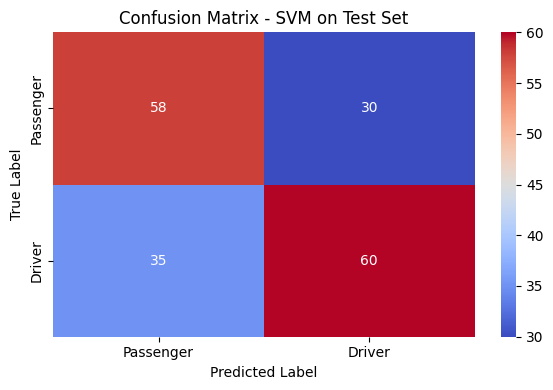

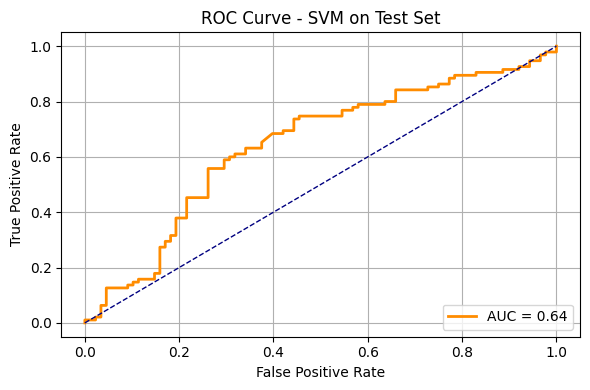

In [29]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# === Plot Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm",
            xticklabels=["Passenger", "Driver"],
            yticklabels=["Passenger", "Driver"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - SVM on Test Set")
plt.tight_layout()
plt.show()

# === Plot ROC Curve ===
if y_prob is not None:
    labels = np.unique(y_test)
    pos_label = labels[1]
    y_proba_pos = y_prob[:, list(labels).index(pos_label)]
    fpr, tpr, _ = roc_curve(y_test, y_proba_pos, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - SVM on Test Set")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### MLP : 

Best parameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.01}
Best cross-validation accuracy: 0.6123843021103295


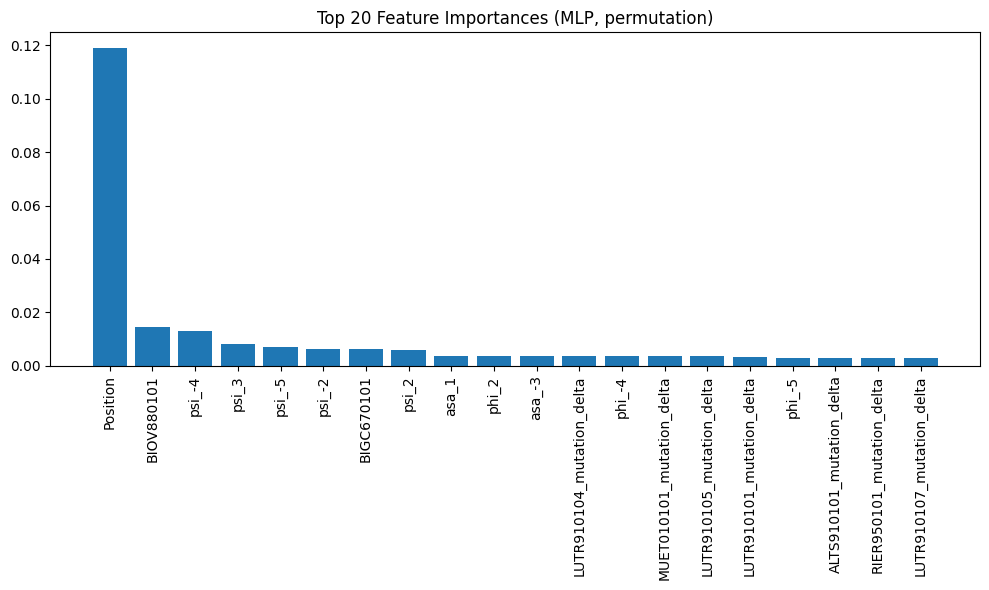

Test set accuracy: 0.5846994535519126
              precision    recall  f1-score   support

      Driver       0.58      0.49      0.53        88
   Passenger       0.59      0.67      0.63        95

    accuracy                           0.58       183
   macro avg       0.58      0.58      0.58       183
weighted avg       0.58      0.58      0.58       183



,Secondary Structure,Sensitivity,Specificity,Accuracy,MCC,AUROC,Samples
0,Coil,0.688312,0.422535,0.560811,0.115037,0.594933,148
1,Helix,0.562500,0.812500,0.687500,0.387298,0.804688,32
2,Strand,1.000000,0.000000,0.666667,0.000000,1.000000,3
3,Overall,0.673684,0.488636,0.584699,0.165252,0.637799,183


In [30]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.inspection import permutation_importance

# Prepare data (feature_cols, X_train, y_train, X_test, y_test already defined)
mlp_param_grid = {
    'hidden_layer_sizes': [(100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.001, 0.01]
}
mlp_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
mlp_grid = GridSearchCV(
    MLPClassifier(max_iter=500, random_state=42),
    mlp_param_grid,
    cv=mlp_cv,
    scoring='accuracy',
    n_jobs=-1
)
mlp_grid.fit(X_train, y_train)

print("Best parameters:", mlp_grid.best_params_)
print("Best cross-validation accuracy:", mlp_grid.best_score_)

# Feature importance via permutation importance
perm = permutation_importance(mlp_grid.best_estimator_, X_train, y_train, n_repeats=5, random_state=42, n_jobs=-1)
sorted_idx = perm.importances_mean.argsort()[::-1]
plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Importances (MLP, permutation)")
plt.bar(range(20), perm.importances_mean[sorted_idx[:20]])
plt.xticks(range(20), [feature_cols[i] for i in sorted_idx[:20]], rotation=90)
plt.tight_layout()
plt.show()

# Evaluate on test set
y_pred_mlp = mlp_grid.predict(X_test)
try:
    y_prob_mlp = mlp_grid.predict_proba(X_test)
except Exception:
    y_prob_mlp = None
print("Test set accuracy:", accuracy_score(y_test, y_pred_mlp))
print(classification_report(y_test, y_pred_mlp))

# Per secondary_structure metrics
mlp_results = []
for sec_class in test_set['secondary_structure'].unique():
    subset = test_set[test_set['secondary_structure'] == sec_class]
    if len(subset) == 0:
        continue
    X_sub = subset[feature_cols]
    y_sub = subset['Class']
    y_pred_sub = mlp_grid.predict(X_sub)
    try:
        y_prob_sub = mlp_grid.predict_proba(X_sub)
    except Exception:
        y_prob_sub = None
    sens, spec, acc, mcc, au = compute_metrics(y_sub, y_pred_sub, y_prob_sub)
    mlp_results.append({
        'Secondary Structure': sec_class,
        'Sensitivity': sens,
        'Specificity': spec,
        'Accuracy': acc,
        'MCC': mcc,
        'AUROC': au,
        'Samples': len(subset)
    })

# Add overall test set metrics
sens, spec, acc, mcc, au = compute_metrics(y_test, y_pred_mlp, y_prob_mlp)
mlp_results.append({
    'Secondary Structure': 'Overall',
    'Sensitivity': sens,
    'Specificity': spec,
    'Accuracy': acc,
    'MCC': mcc,
    'AUROC': au,
    'Samples': len(y_test)
})

mlp_results_df = pd.DataFrame(mlp_results)
display(mlp_results_df)

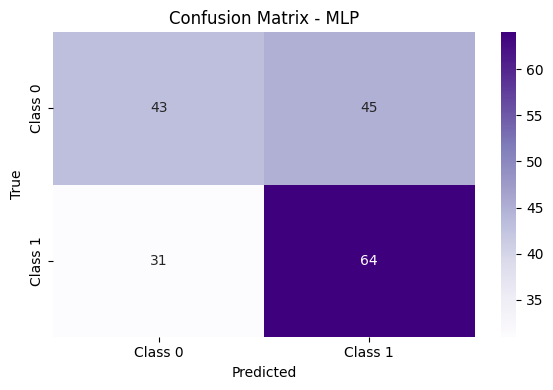

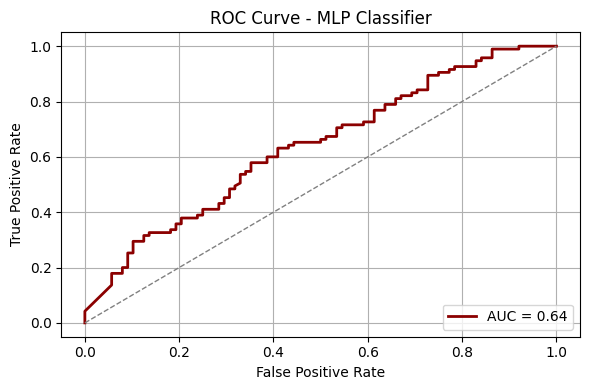

In [31]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# === Confusion Matrix ===
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_mlp, annot=True, fmt="d", cmap="Purples",
            xticklabels=["Class 0", "Class 1"],
            yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - MLP")
plt.tight_layout()
plt.show()

# === ROC Curve ===
if y_prob_mlp is not None:
    labels = np.unique(y_test)
    pos_label = labels[1]  # Assumes binary classification
    y_proba_pos = y_prob_mlp[:, list(labels).index(pos_label)]
    fpr, tpr, _ = roc_curve(y_test, y_proba_pos, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color="darkred", lw=2, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - MLP Classifier")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("ROC curve not available: model does not support probability estimates.")


### XGBoost:

Fitting 5 folds for each of 2 candidates, totalling 10 fits


c:\Users\CYTech Student\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:04:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 1.0}
Best cross-validation accuracy: 0.7342788790157211


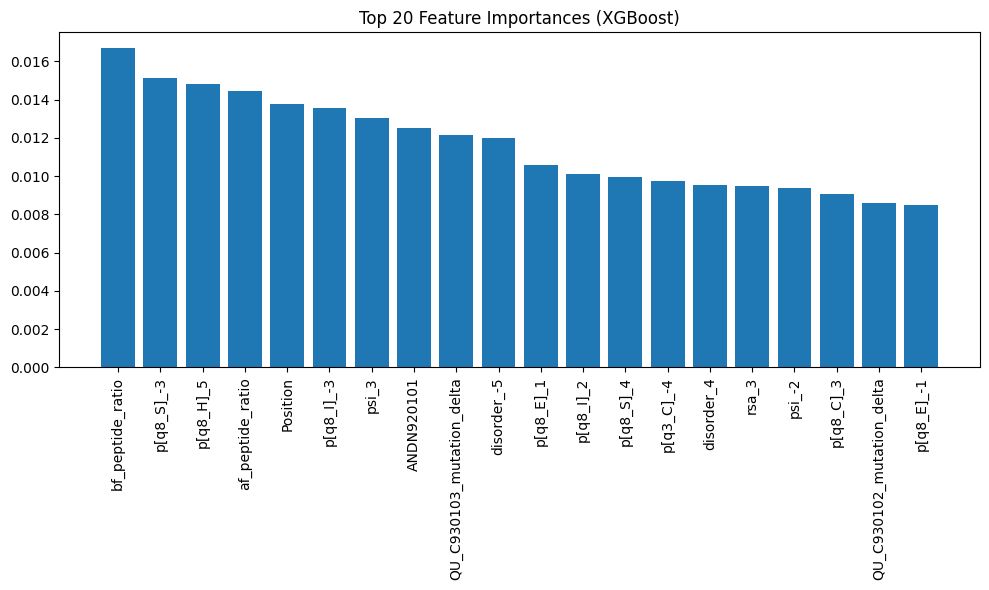

Test set accuracy: 0.7377049180327869
              precision    recall  f1-score   support

           0       0.73      0.72      0.72        88
           1       0.74      0.76      0.75        95

    accuracy                           0.74       183
   macro avg       0.74      0.74      0.74       183
weighted avg       0.74      0.74      0.74       183



,Secondary Structure,Sensitivity,Specificity,Accuracy,MCC,AUROC,Samples
0,Coil,0.753247,0.690141,0.722973,0.444487,0.760380,148
1,Helix,0.750000,0.875000,0.812500,0.629941,0.828125,32
2,Strand,1.000000,0.000000,0.666667,0.000000,1.000000,3
3,Overall,0.757895,0.715909,0.737705,0.474315,0.780144,183


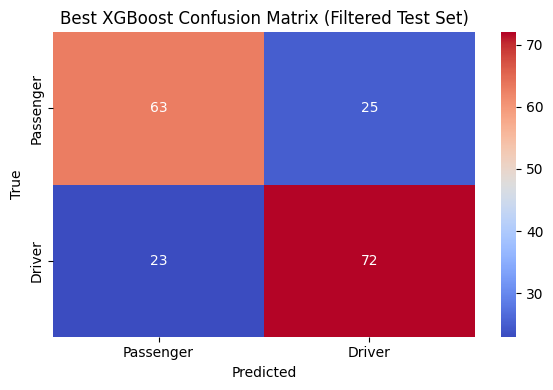

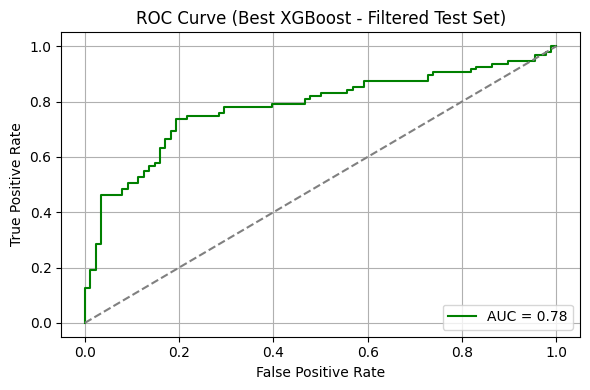

In [37]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, matthews_corrcoef, roc_auc_score, roc_curve, auc
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, recall_score
from xgboost import XGBClassifier





original_columns = X_train.columns.tolist()
# Keep numeric features
X_train = X_train.select_dtypes(include=["float64", "int64"])
X_test = X_test.select_dtypes(include=["float64", "int64"])

# Clean column names for XGBoost
X_train.columns = X_train.columns.astype(str).str.replace(r"[<>[\]]", "_", regex=True)
X_test.columns = X_test.columns.astype(str).str.replace(r"[<>[\]]", "_", regex=True)

y_train = (training_set["Class"] == "Passenger").astype(int)
y_test = (test_set["Class"] == "Passenger").astype(int)

# === Step 5: Set up GridSearchCV ===
recall_driver = make_scorer(recall_score, pos_label=1)

param_grid = {
    'max_depth': [4, 6],
    'learning_rate': [0.1],
    'n_estimators': [100],
    'subsample': [1.0],
    'colsample_bytree': [1.0],
    'gamma': [0]
}

xgb_clf = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring=recall_driver,
    cv=5,
    verbose=2,
    n_jobs=-1
)

# === Step 6: Fit best model ===
grid_search.fit(X_train, y_train)
xgb_grid= grid_search.best_estimator_


print("Best parameters:", grid_search.best_params_)


print("Best cross-validation accuracy:", grid_search.best_score_)

# Feature importance (gain)
importances = xgb_grid.feature_importances_
indices = importances.argsort()[::-1]
plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Importances (XGBoost)")
plt.bar(range(20), importances[indices[:20]])
plt.xticks(range(20), [feature_cols[i] for i in indices[:20]], rotation=90)
plt.tight_layout()
plt.show()

# Evaluate on test set
y_pred_xgb = xgb_grid.predict(X_test)
try:
    y_prob_xgb = xgb_grid.predict_proba(X_test)
except Exception:
    y_prob_xgb = None
print("Test set accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))



# Per secondary_structure metrics
xgb_results = []
for sec_class in test_set['secondary_structure'].unique():
    subset = test_set[test_set['secondary_structure'] == sec_class]
    if len(subset) == 0:
        continue
    X_sub = subset[feature_cols]
    X_sub.columns = X_sub.columns.astype(str).str.replace(r"[<>[\]]", "_", regex=True)
    y_sub = subset['Class']
    y_sub = (y_sub == "Passenger").astype(int)
    y_pred_sub = xgb_grid.predict(X_sub)
    try:
        y_prob_sub = xgb_grid.predict_proba(X_sub)
    except Exception:
        y_prob_sub = None
    sens, spec, acc, mcc, au = compute_metrics(y_sub, y_pred_sub, y_prob_sub)
    xgb_results.append({
        'Secondary Structure': sec_class,
        'Sensitivity': sens,
        'Specificity': spec,
        'Accuracy': acc,
        'MCC': mcc,
        'AUROC': au,
        'Samples': len(subset)
    })

# Add overall test set metrics
sens, spec, acc, mcc, au = compute_metrics(y_test, y_pred_xgb, y_prob_xgb)
xgb_results.append({
    'Secondary Structure': 'Overall',
    'Sensitivity': sens,
    'Specificity': spec,
    'Accuracy': acc,
    'MCC': mcc,
    'AUROC': au,
    'Samples': len(y_test)
})

xgb_results_df = pd.DataFrame(xgb_results)
display(xgb_results_df)


# === Confusion Matrix ===
cm_best = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_best, annot=True, fmt="d", cmap="coolwarm",
            xticklabels=["Passenger", "Driver"],
            yticklabels=["Passenger", "Driver"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Best XGBoost Confusion Matrix (Filtered Test Set)")
plt.tight_layout()
plt.show()
# === ROC Curve ===
y_proba_best = xgb_grid.predict_proba(X_test)[:, 1]
fpr_best, tpr_best, _ = roc_curve(y_test, y_proba_best)
roc_auc_best = auc(fpr_best, tpr_best)

plt.figure(figsize=(6, 4))
plt.plot(fpr_best, tpr_best, label=f"AUC = {roc_auc_best:.2f}", color="green")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Best XGBoost - Filtered Test Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

### Random forests

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation recall: 0.765516062884484


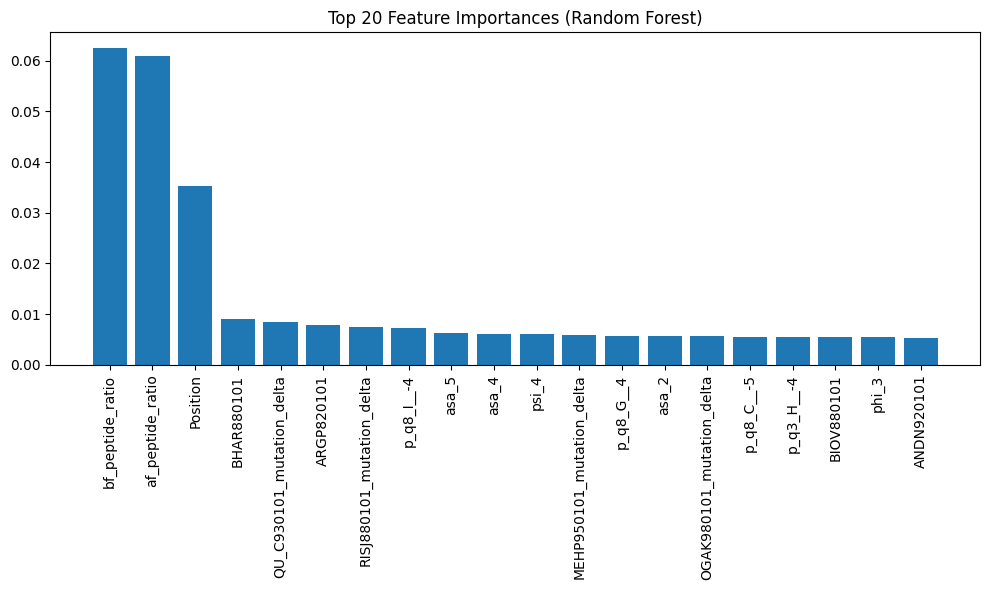

Test set accuracy: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.68      0.59      0.63        88
           1       0.66      0.74      0.70        95

    accuracy                           0.67       183
   macro avg       0.67      0.66      0.66       183
weighted avg       0.67      0.67      0.66       183



,Secondary Structure,Sensitivity,Specificity,Accuracy,MCC,AUROC,Samples
0,Coil,0.753247,0.577465,0.668919,0.336517,0.710627,148
1,Helix,0.625000,0.687500,0.656250,0.313112,0.722656,32
2,Strand,1.000000,0.000000,0.666667,0.000000,0.000000,3
3,Overall,0.736842,0.590909,0.666667,0.331703,0.707536,183


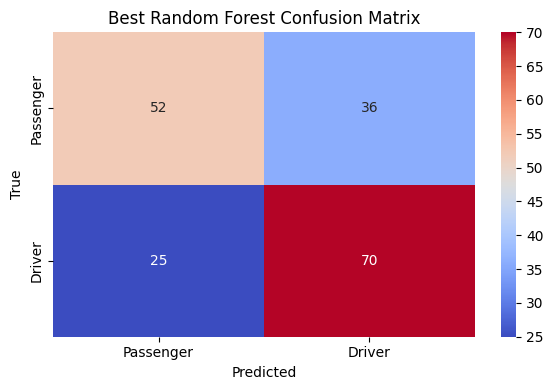

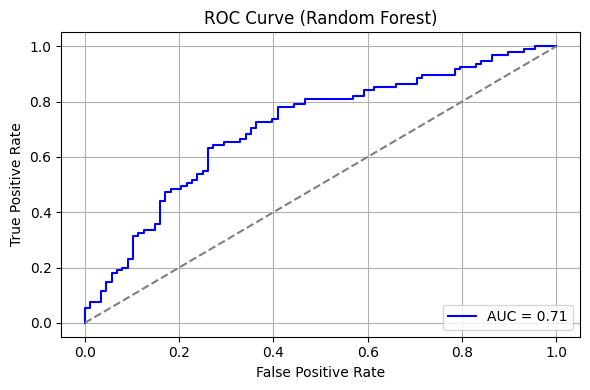

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, matthews_corrcoef, roc_auc_score, roc_curve, auc, make_scorer, recall_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Keep numeric features
X_train = X_train.select_dtypes(include=["float64", "int64"])
X_test = X_test.select_dtypes(include=["float64", "int64"])

# Clean column names
X_train.columns = X_train.columns.astype(str).str.replace(r"[<>\[\]]", "_", regex=True)
X_test.columns = X_test.columns.astype(str).str.replace(r"[<>\[\]]", "_", regex=True)

# Target conversion
y_train = (training_set["Class"] == "Passenger").astype(int)
y_test = (test_set["Class"] == "Passenger").astype(int)

# GridSearchCV with RandomForest
recall_driver = make_scorer(recall_score, pos_label=1)
param_grid_rf = {
    'n_estimators': [100],
    'max_depth': [10, 20],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt']
}

rf_clf = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(
    estimator=rf_clf,
    param_grid=param_grid_rf,
    scoring=recall_driver,
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid_search_rf.fit(X_train, y_train)
rf_best = grid_search_rf.best_estimator_

print("Best parameters:", grid_search_rf.best_params_)
print("Best cross-validation recall:", grid_search_rf.best_score_)

# Feature importance
importances = rf_best.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Importances (Random Forest)")
plt.bar(range(20), importances[indices[:20]])
plt.xticks(range(20), [X_train.columns[i] for i in indices[:20]], rotation=90)
plt.tight_layout()
plt.show()

# Predictions
y_pred_rf = rf_best.predict(X_test)
y_prob_rf = rf_best.predict_proba(X_test)

print("Test set accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))



# Evaluate by secondary structure
rf_results = []
for sec_class in test_set['secondary_structure'].unique():
    subset = test_set[test_set['secondary_structure'] == sec_class]
    if len(subset) == 0:
        continue
    X_sub = subset[feature_cols]
    X_sub.columns = X_sub.columns.astype(str).str.replace(r"[<>\[\]]", "_", regex=True)
    y_sub = (subset['Class'] == "Passenger").astype(int)
    y_pred_sub = rf_best.predict(X_sub)
    y_prob_sub = rf_best.predict_proba(X_sub)
    sens, spec, acc, mcc, au = compute_metrics(y_sub, y_pred_sub, y_prob_sub)
    rf_results.append({
        'Secondary Structure': sec_class,
        'Sensitivity': sens,
        'Specificity': spec,
        'Accuracy': acc,
        'MCC': mcc,
        'AUROC': au,
        'Samples': len(subset)
    })

# Overall metrics
sens, spec, acc, mcc, au = compute_metrics(y_test, y_pred_rf, y_prob_rf)
rf_results.append({
    'Secondary Structure': 'Overall',
    'Sensitivity': sens,
    'Specificity': spec,
    'Accuracy': acc,
    'MCC': mcc,
    'AUROC': au,
    'Samples': len(y_test)
})

rf_results_df = pd.DataFrame(rf_results)
display(rf_results_df)

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="coolwarm",
            xticklabels=["Passenger", "Driver"],
            yticklabels=["Passenger", "Driver"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Best Random Forest Confusion Matrix")
plt.tight_layout()
plt.show()

# ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(6, 4))
plt.plot(fpr_rf, tpr_rf, label=f"AUC = {roc_auc_rf:.2f}", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Random Forest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
